> If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor

> A group of pre dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method

# Voting Classifier

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1)

<p align='center'>
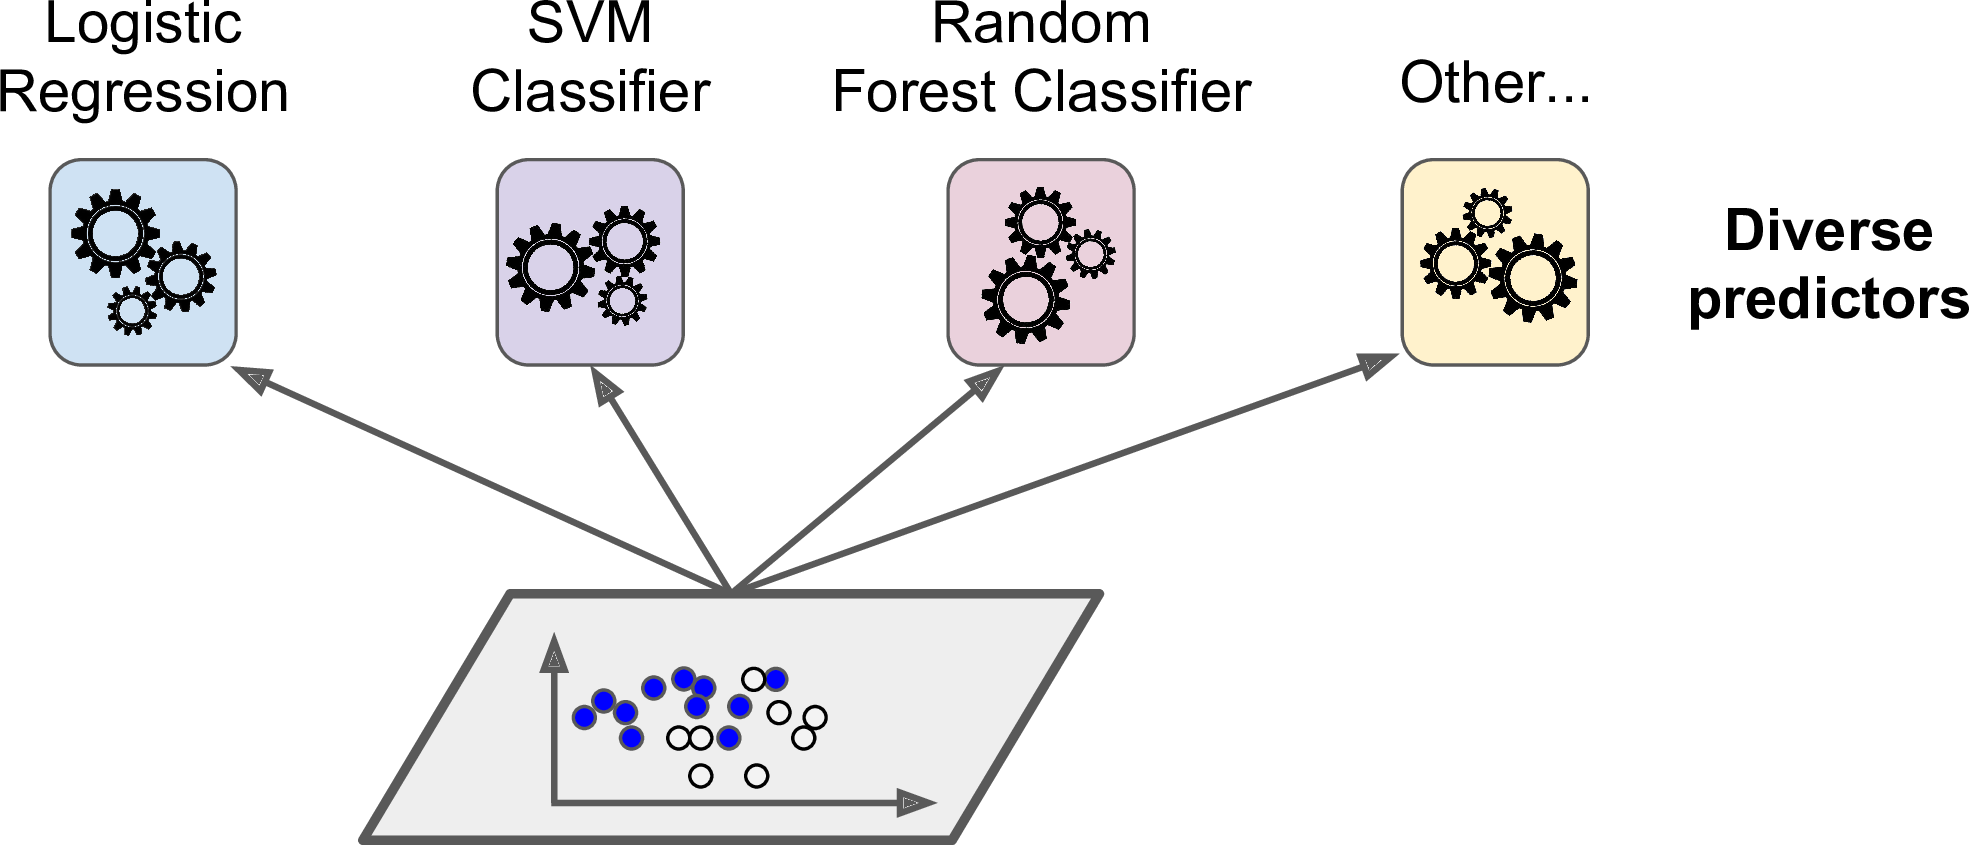
</p>
Figure 7-1. Training diverse classifier

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier (see Figure 7-2)

<p align='center'>
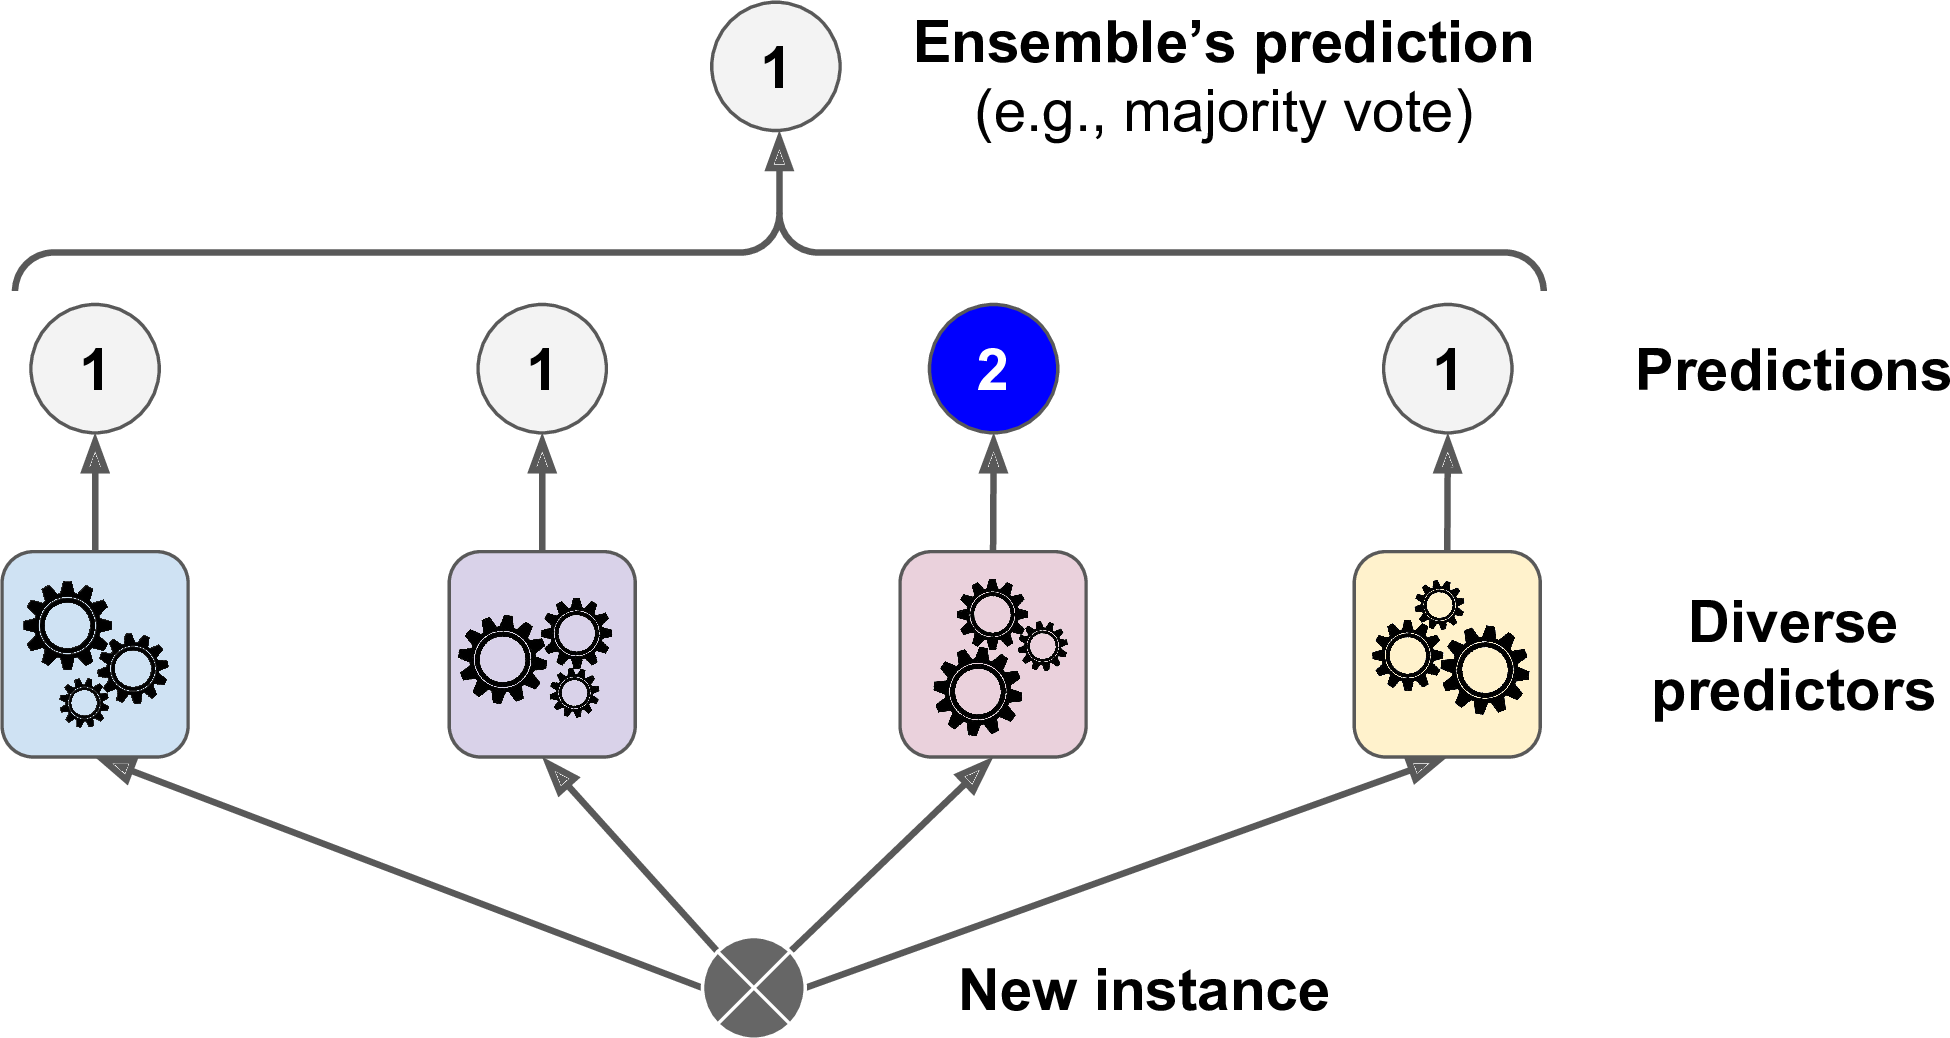
</p>
Figure 7-2. Hard voting classifier predictions

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse

How is this possible? The following analogy can help shed some light on this mystery

Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%

The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%)

Figure 7-3 shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventu ally all 10 series end up so close to 51% that they are consistently above 50%

<p align='center'>
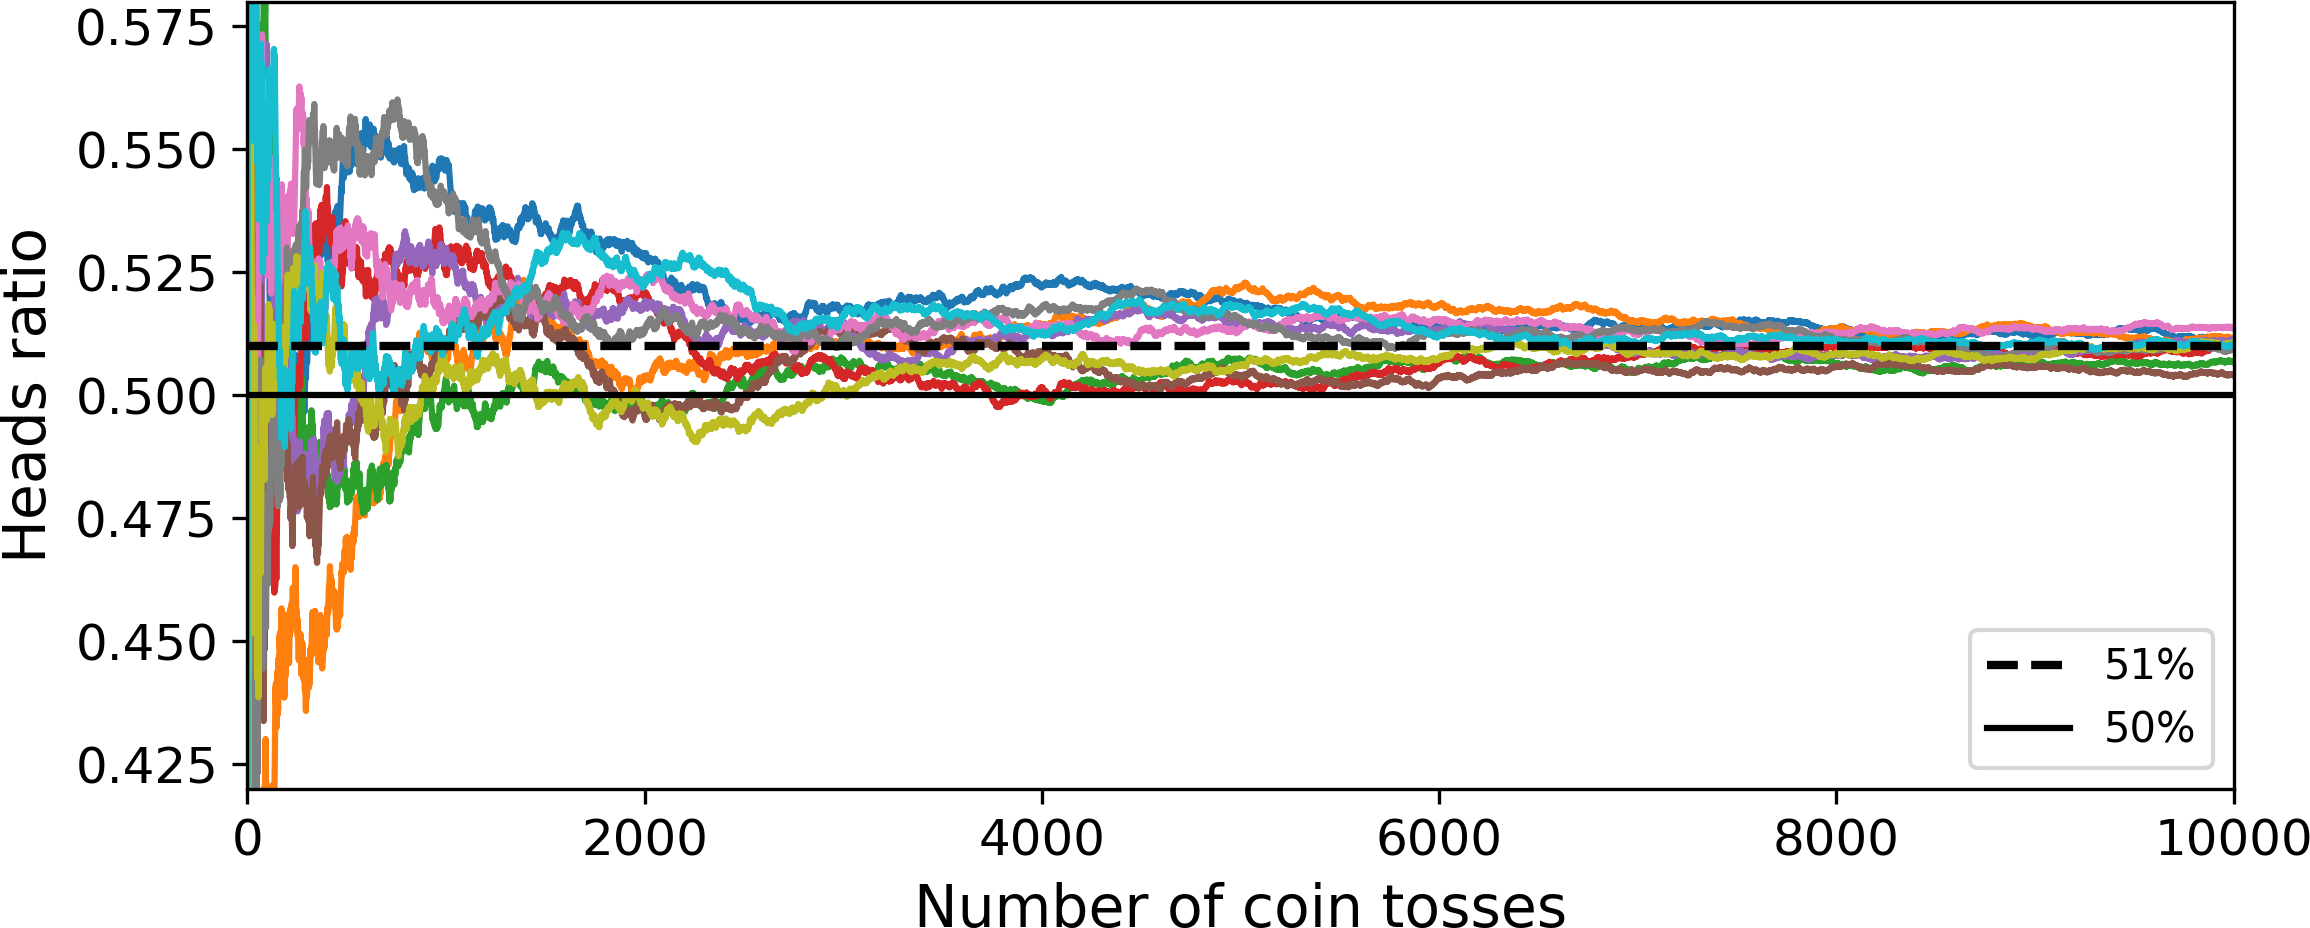
</p>
Figure 7-3. The law of large numbers

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset, introduced in Chapter 5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

Let’s look at each classifier’s accuracy on the test set

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.888


There you have it! The voting classifier slightly outperforms all the individual classifiers

If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called sof voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes


All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities

This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method)

If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy



# Bagging and Pasting


One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set

When sampling is performed with replacement, this method is called bagging (meaning that the individual data points can be chosen more than once) (short for bootstrap aggregating). When sampling is performed without replacement (each subset of the sample can be used once at most), it is called pasting

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure 7-4

<p align='center'>
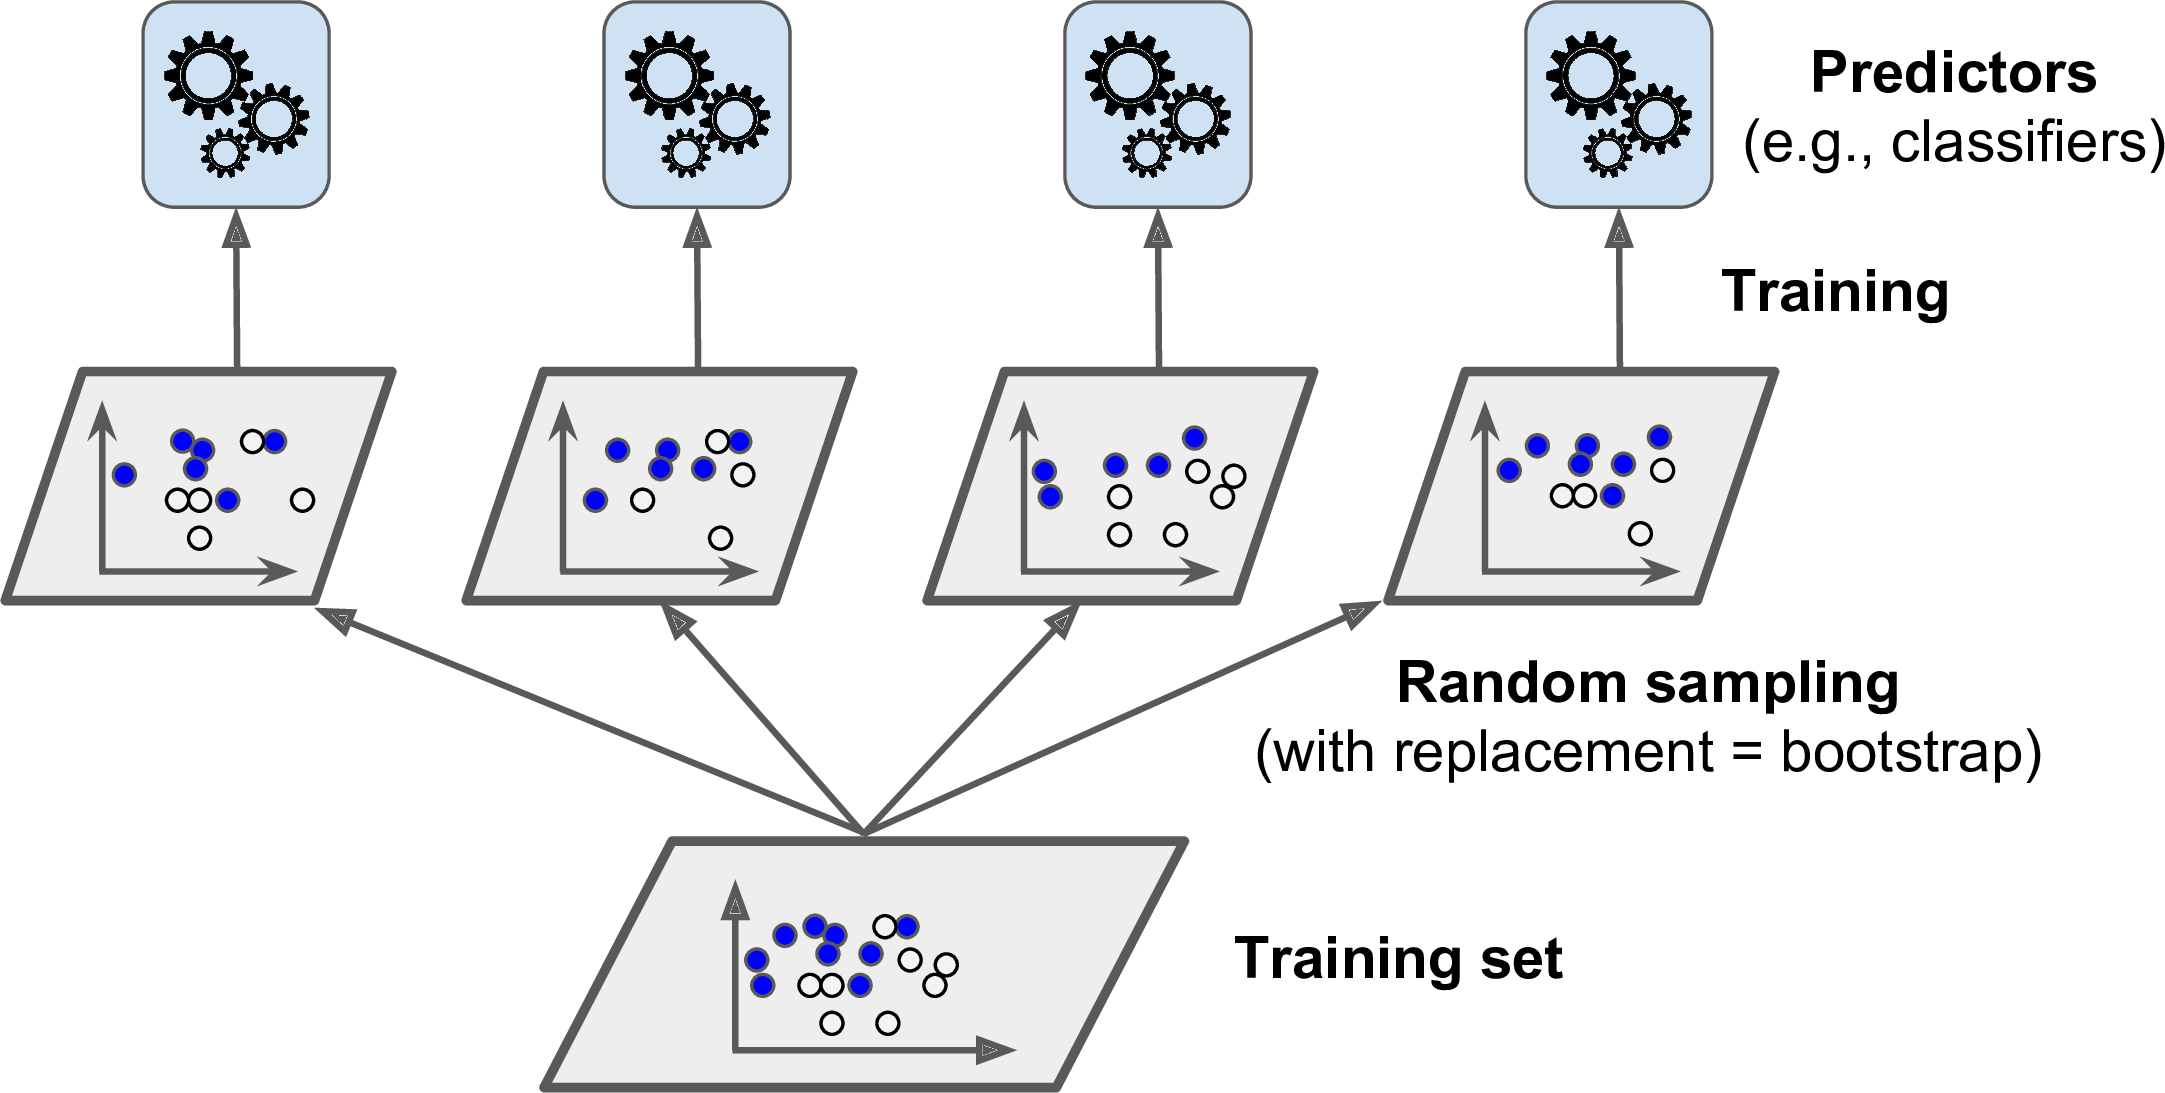
</p>
Figure 7-4. Pasting/bagging training set sampling and training

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors

The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set

As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well

# Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression)

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False)

The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

Figure 7-5 compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular)

<p align='center'>
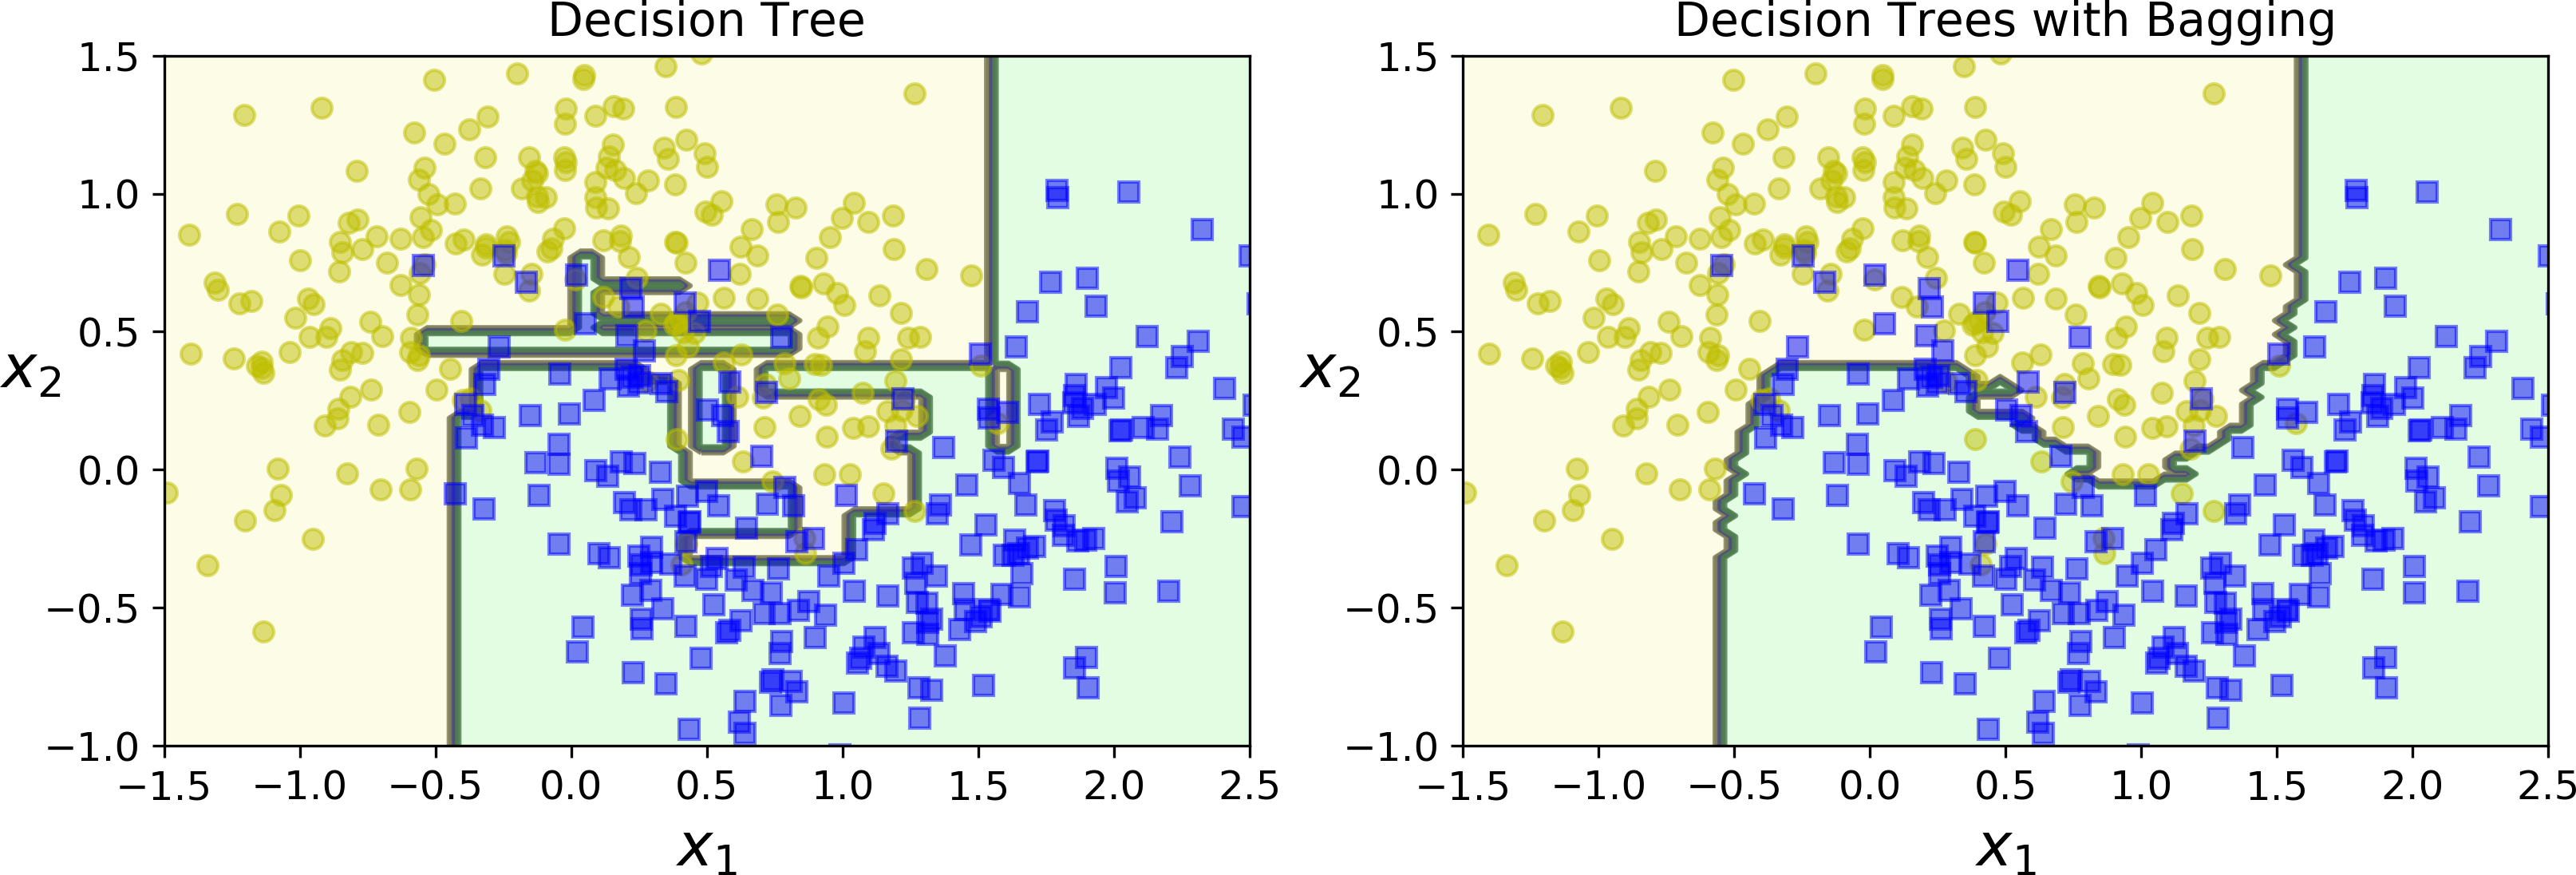
</p>
Figure 7-5. A single Decision Tree versus a bagging ensemble of 500 trees

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced

Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross validation to evaluate both bagging and pasting and select the one that works best

# Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement  (bootstrap=True), where m is the size of the training set

This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor



> As m grows, this ratio approaches $ 1 - exp(-1) \approx 63.212%$

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training

The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [ ]:
bag_clf.oob_score_

0.9013333333333333

According to this oob evaluation, this is likely to achieve about BaggingClassifier 89.3% accuracy on the test set. Let’s verify this

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

We get 89.6% accuracy on the test set—close enough

The oob decision function for each training instance is also available through the oob_decision_function_ variable. In this case (since the base estimator has a predict_proba() method) the decision function returns the class probabilities for each training instance

For example, the oob evaluation estimates that the first training instance has a 68.25% probability of belonging to the positive class (and 31.75% of belonging to the negative class)

In [ ]:
bag_clf.oob_decision_function_

array([[0.01764706, 0.98235294],
       [0.05494505, 0.94505495],
       [0.80213904, 0.19786096],
       [1.        , 0.        ],
       [0.71428571, 0.28571429],
       [0.09497207, 0.90502793],
       [0.99502488, 0.00497512],
       [0.        , 1.        ],
       [0.54117647, 0.45882353],
       [0.02061856, 0.97938144],
       [0.93434343, 0.06565657],
       [1.        , 0.        ],
       [0.2247191 , 0.7752809 ],
       [0.6440678 , 0.3559322 ],
       [0.        , 1.        ],
       [0.98901099, 0.01098901],
       [1.        , 0.        ],
       [0.98285714, 0.01714286],
       [0.80606061, 0.19393939],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.74093264, 0.25906736],
       [1.        , 0.        ],
       [0.00598802, 0.99401198],
       [0.13684211, 0.86315789],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.31952663, 0.68047337],
       [0.99492386, 0.00507614],
       [0.

# Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: max_features and bootstrap_feautres. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the Random Patches method

Keeping all training instances (i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e., bootstrap_feautres=True and/or max_features smaller than 1.0) is called the Random Subspace method 

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance

# Random Forests

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks) 



The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the esemble itself

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features

This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model

The following is BaggingClassifier roughly equivalent to the previous RandomForestClassifier

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do)

A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble (or Extra-Trees for short)

Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree

You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class

Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class

> It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search)

## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable

For example, the following code trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unim portant in comparison (11% and 2%, respectively)


In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.1009888403055288
sepal width (cm) 0.02309048721362586
petal length (cm) 0.4213142688699516
petal width (cm) 0.45460640361089383


Similarly, if you train a Random Forest classifier on the MNIST dataset (introduced in Chapter 3) and plot each pixel’s importance, you get the image represented in Figure 7-6

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = minst.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
  image = data.reshape(28, 28)
  plt.figure(figsize=(10, 8))
  plt.imshow(image, cmap = mpl.cm.hot,
              interpolation='nearest')
  plt.axis('off')

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

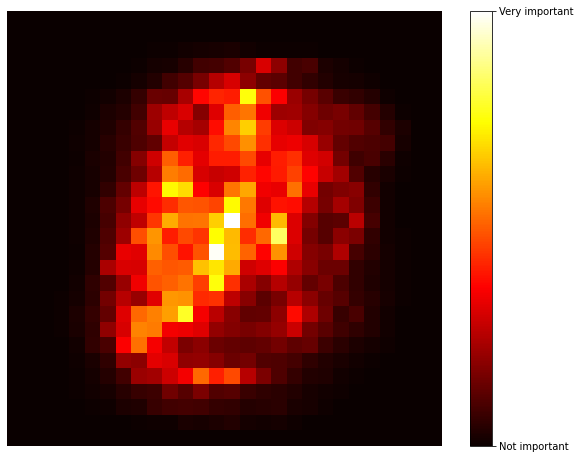

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

Figure 7-6. MNIST pixel importance (according to a Random Forest classifier

# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner

The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor

There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting


## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted

This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on (see Figure 7-7)

<p align='center'>
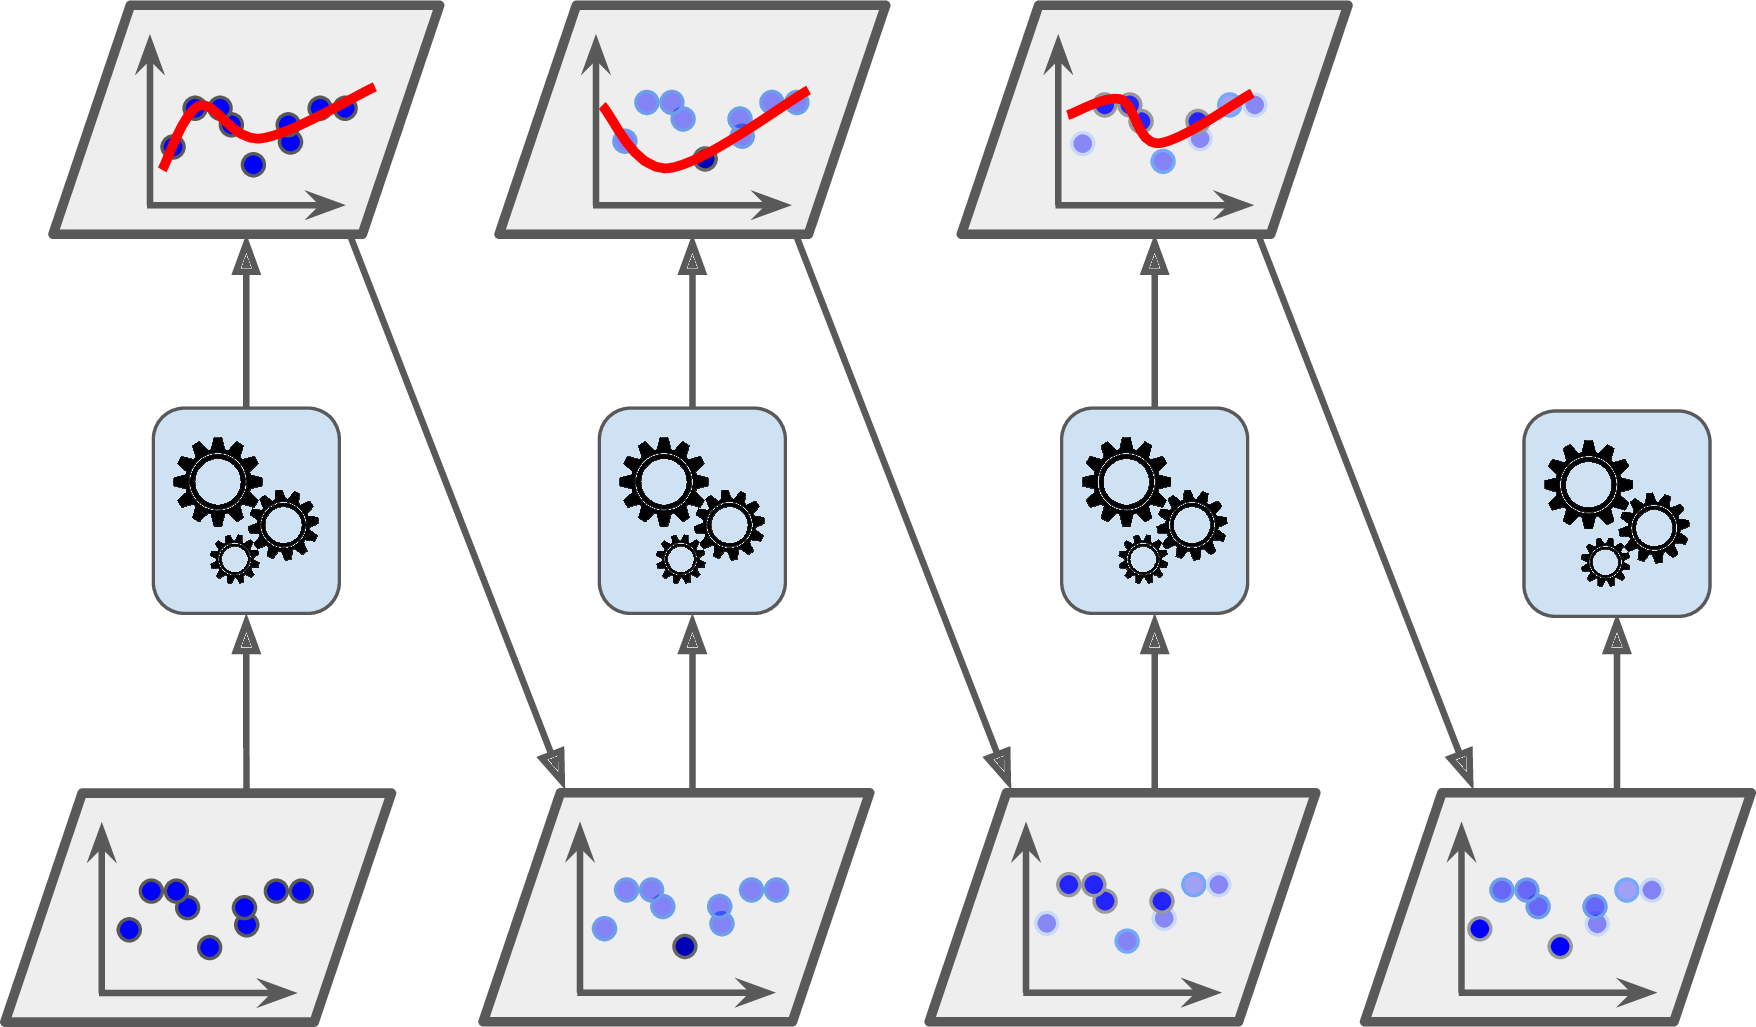
</p>

Figure 7-7. AdaBoost sequential training with instance weight updates

Figure 7-8 shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel)

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on

The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration)

As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’ parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better

<p align='center'>
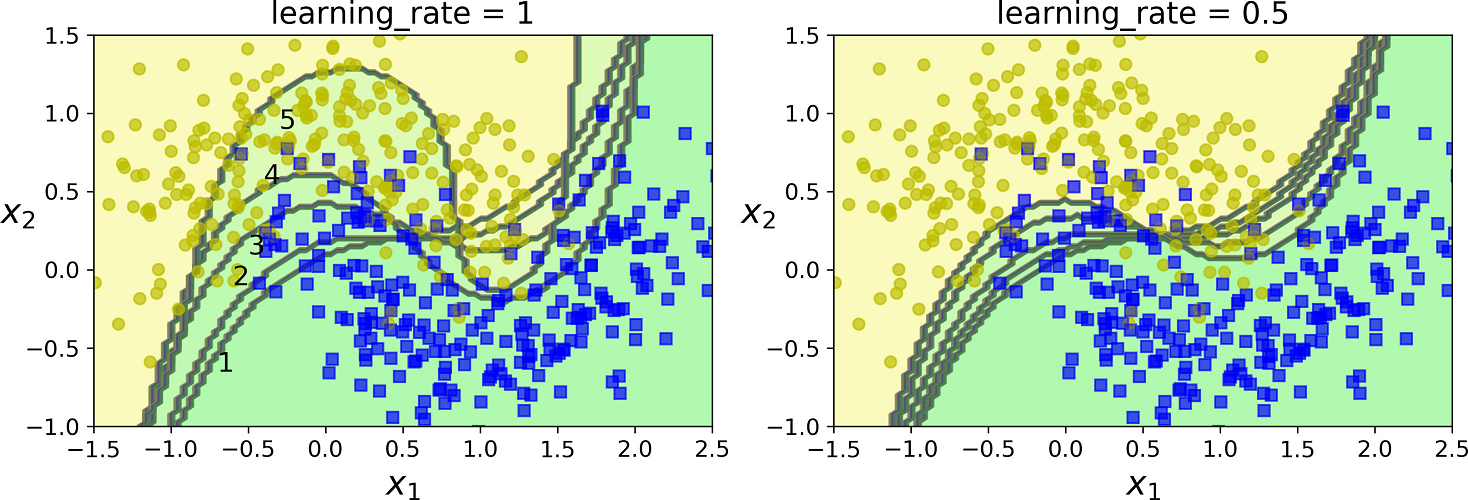
</p>
Figure 7-8. Decision boundaries of consecutive predictors

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set

> There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting

Let’s take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ set to is initially $\frac 1m$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set; see Equation 7-1

Equation 7-1. Weighted error rate of the $j^{th}$ predictor

$$ r_j = {{\underset {\hat y^{(i)}_j \neq y^{(i)}}{\sum^m_{i=1} {w^{(i)}}}} \over {\sum^m_{i = 1} w^{(i)}}} $$

where $\hat y^{(i)}_j$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance

The predictor’s weight $a_j$ is then computed using Equation 7-2, where $\eta$ is the learning rate hyperparameter (defaults to 1)

The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero

However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative


Equation 7-2. Predictor weight

$$ \alpha_j = \eta log \frac{1- r_j}{r_j} $$

Next the instance weights are updated using Equation 7-3: the misclassified instances are boosted

Equation 7-3. Weight update rule

$$ \text{for i} = 1,2,\dots,m \\ w^{(i)} \leftarrow \begin{cases} w^{(i)}\text{ if } \hat y_j^{(i)} = y^{(i)} \\ w^{(i)} exp (\alpha_j)  \text{ if } \hat y_j^{(i)} \neq y^{(i)} \end{cases} $$

Then all the instance weights are normalized (i.e., divided by $\sum^,_{i = 1} w^{(i)}$